# Hypermorph notebook

In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gc
import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import nibabel as nib
import neurite as ne
import voxelmorph as vxm
import stabilize2p
import mpl_toolkits.axisartist as AA
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    low, hig = video[0].min(), video[1].max()
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.pystackreg-affine.tif',
]

RANDOM_SEED = 1

os.makedirs('report', exist_ok=True)

# Load model

In [3]:
weights_path = '../models/hypm_drosophila_2d_0100.h5'

# get shape
inshape = tiff.imread(orig_examples[0], key=0).shape
nfeats = 1
print(f'{inshape=}')

# other options
int_steps = 7
int_downsize = 2

# unet architecture
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

# build model
vxm_model = vxm.networks.HyperVxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    int_steps=int_steps,
    int_resolution=int_downsize,
    src_feats=nfeats,
    trg_feats=nfeats,
    svf_resolution=2,
)

# load weights
vxm_model.load_weights(weights_path)

# print model info
vxm_model.summary(line_length=180)

inshape=(480, 736)
Instructions for updating:
Use fn_output_signature instead
Model: "hyper_vxm_dense"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 hyper_vxm_dense_hyp_input (InputLayer)                    [(None, 1)]                             0                    []                                                          
                                                                                                                                                                                    
 hyper_vxm_dense_hyp_dense_1 (Dense)                       (None, 128)                             256                  ['hyper_vxm_dense_hyp_input[0][0]']                  

## Register image

prepare validation tensor,

In [47]:
image_path = orig_examples[4]
keys = [range(50)]

store_params = []
base_gen = stabilize2p.utils.vxm_data_generator(image_path,
                                                keys=keys,
                                                training=False,
                                                store_params=store_params)
validation = [inputs for (inputs, _) in base_gen]

del base_gen
gc.collect()

moving = np.concatenate([m for m, _ in validation], axis=0)
fixed = np.concatenate([f for _, f in validation], axis=0)

del validation
gc.collect()

print(f'{moving.shape=} | {fixed.shape=}')

[2022-01-01 03:32:12,376] I T139794692059968 utils.py:231: Calculated "first" fixed references in 0.278s


moving.shape=(50, 480, 736, 1) | fixed.shape=(50, 480, 736, 1)


In [48]:
# inference
moved = []
t1 = time.perf_counter()
for hyp in np.linspace(0, 1, 20):
    print(f'registering with {hyp=} ..')
    hyp = np.tile([[hyp]], (moving.shape[0], 1)).astype('float32')  # reformat hyperparam

    # prepare for model inference
    inputs = (moving, fixed, hyp)
    img = vxm_model.predict(inputs)[0].squeeze()
    moved += [img]
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.2f}s | {20*moving.shape[0]/(t2-t1):.0f} frames/s | {(t2-t1)/(20*moving.shape[0]):.2f} s/frame')

moved = np.stack(moved, axis=-1)
print(f'{moved.shape=}')

registering with hyp=0.0 ..
registering with hyp=0.05263157894736842 ..
registering with hyp=0.10526315789473684 ..
registering with hyp=0.15789473684210525 ..
registering with hyp=0.21052631578947367 ..
registering with hyp=0.2631578947368421 ..
registering with hyp=0.3157894736842105 ..
registering with hyp=0.3684210526315789 ..
registering with hyp=0.42105263157894735 ..
registering with hyp=0.47368421052631576 ..
registering with hyp=0.5263157894736842 ..
registering with hyp=0.5789473684210527 ..
registering with hyp=0.631578947368421 ..
registering with hyp=0.6842105263157894 ..
registering with hyp=0.7368421052631579 ..
registering with hyp=0.7894736842105263 ..
registering with hyp=0.8421052631578947 ..
registering with hyp=0.894736842105263 ..
registering with hyp=0.9473684210526315 ..
registering with hyp=1.0 ..
Elapsed 50.49s | 20 frames/s | 0.05 s/frame
moved.shape=(50, 480, 736, 20)


plot results,

plotting different outputs for frame 0


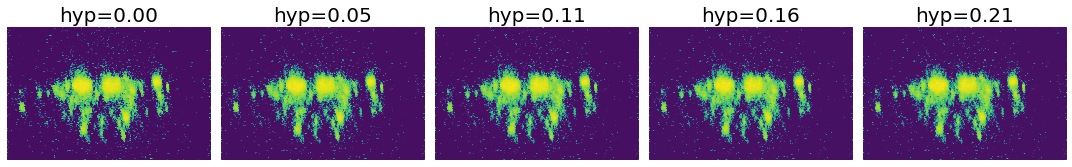

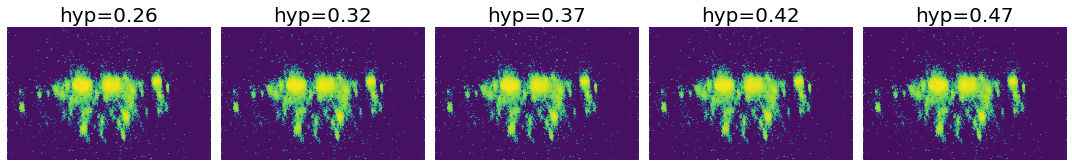

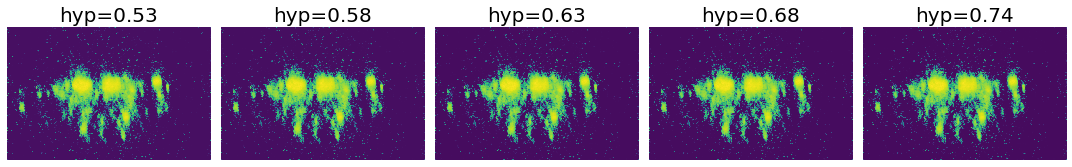

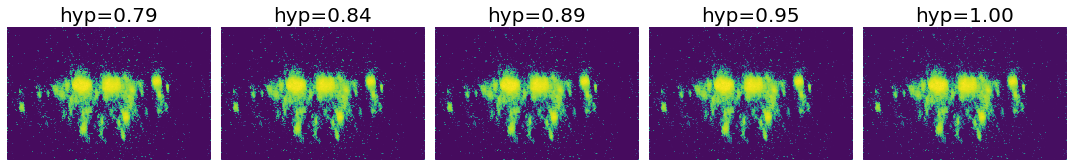

In [49]:
sample_i = 0
N = 5

print(f'plotting different outputs for frame {sample_i}')

for k in range(0, 20, N):
    images = [moved[sample_i, ..., i] for i in range(k, k+N)]
    titles = [f'hyp={i/19:.2f}' for i in range(k, k+N)]
    cmaps = ['viridis'] * N
    ne.plot.slices(images, titles=titles, cmaps=cmaps);

evaluate metrics,

In [50]:
from stabilize2p.metrics import MSE, COM, NCC, EMD
metrics = [MSE, COM, NCC, EMD]
scores = {v.__name__: [] for v in metrics}

for i, hyp in enumerate(np.linspace(0, 1, 20)):
    print('-'*32)
    for func in metrics:
        t1 = time.perf_counter()
        score = func(moved[..., i])
        t2 = time.perf_counter()
        print(f'hyp: {hyp:.2f} | {t2-t1:.3f}s | {func.__name__}: {score}')
        scores[func.__name__] += [score]

--------------------------------
hyp: 0.00 | 0.183s | MSE: 0.008373875170946121
hyp: 0.00 | 0.116s | COM: 0.0
hyp: 0.00 | 1.212s | NCC: -0.45876264572143555
hyp: 0.00 | 0.947s | EMD: 28.531991088742586
--------------------------------
hyp: 0.05 | 0.191s | MSE: 0.009191852062940598
hyp: 0.05 | 0.116s | COM: 0.0
hyp: 0.05 | 1.206s | NCC: -0.3901476263999939
hyp: 0.05 | 1.040s | EMD: 28.79612788071878
--------------------------------
hyp: 0.11 | 0.189s | MSE: 0.009756134822964668
hyp: 0.11 | 0.116s | COM: 0.0
hyp: 0.11 | 1.210s | NCC: -0.3657239079475403
hyp: 0.11 | 0.977s | EMD: 27.98583904782234
--------------------------------
hyp: 0.16 | 0.186s | MSE: 0.010162183083593845
hyp: 0.16 | 0.116s | COM: 0.0
hyp: 0.16 | 1.208s | NCC: -0.3524816930294037
hyp: 0.16 | 0.955s | EMD: 27.94576377809209
--------------------------------
hyp: 0.21 | 0.187s | MSE: 0.01052265428006649
hyp: 0.21 | 0.117s | COM: 0.0
hyp: 0.21 | 1.210s | NCC: -0.3417014181613922
hyp: 0.21 | 0.936s | EMD: 28.18111080164427

MSE | min:     0.008374 hyp: 0.000000 | max:     0.012136 hyp: 1.000000
COM | min:     0.000000 hyp: 0.000000 | max:     0.000000 hyp: 0.000000
NCC | min:    -0.458763 hyp: 0.000000 | max:    -0.274072 hyp: 1.000000
EMD | min:    25.188910 hyp: 0.947368 | max:    28.796128 hyp: 0.052632


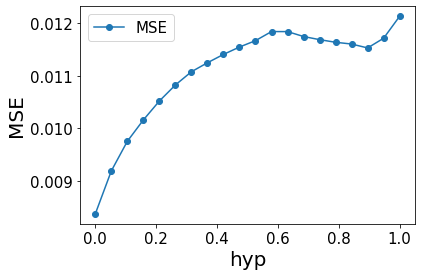

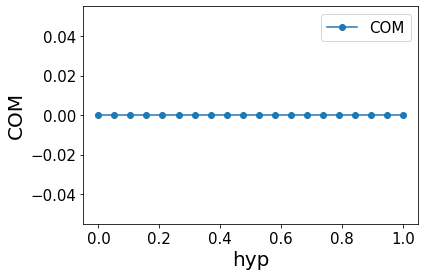

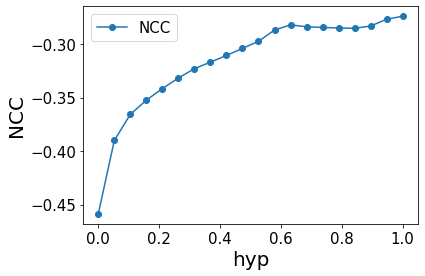

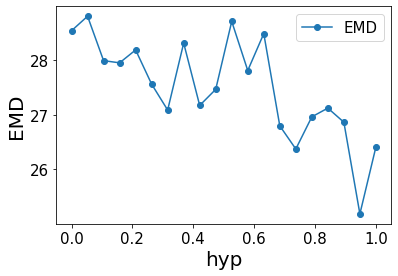

In [52]:
hyp_array = np.linspace(0, 1, 20)

def plot_score(name, values):
    _, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(hyp_array, values, '-o', color='tab:blue', label=name)
    ax.set_xlabel('hyp')
    ax.set_ylabel(name)
    ax.legend()

for k, v in scores.items():
    min_hyp = hyp_array[np.argmin(v)]
    max_hyp = hyp_array[np.argmax(v)]
    print(f'{k} | min: {np.min(v):12f} hyp: {min_hyp:2f} | max: {np.max(v):12f} hyp: {max_hyp:2f}')

for k, v in scores.items():
    plot_score(k, v)